In [17]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import math
import random
import pickle
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from scipy import stats,spatial

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor


from sklearn.linear_model import ElasticNet

In [18]:
data = pd.read_csv('C:\\Users\\dtulomba\\Documents\\ProjetsCours\\projet4\\2016_Building_Energy_Benchmarking_cleaned.csv', sep=',')

In [19]:
data.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'distance_center', 'nb_use_types',
       'Electricity', 'SteamUse', 'NaturalGas', 'Buildings Consumption',
       'Neighborhood Consumption'],
      dtype='object')

### Pipeline

Définition du Pipeline incluant le pré-traitement

Nous procédons à une validation croisée pour sélectionner les hyperparamètres et le modèle.

Pour que le prétraitement soit réalisé sans fuite de données, nous utiliserons un « pipeline ».
Définition du prétraitement différencié selon les colonnes

Nous appliquerons un pré-traitement différencié selon que les caractéristiques sont quantitatives ou catégorielles. Dans cette partie, nous définissons ce pré-traitement dans un pipe-line pour usage ultérieur, intégré à la validation croisée.

    - imputation
    - target encoding
    - standardisation



In [20]:
data_pipeline = data.copy()

### Initialisation de la pipeline

In [21]:
#data = pd.read_csv('data.csv')
X = data_pipeline.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'], axis=1)
y = data_pipeline['TotalGHGEmissions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the numeric features and categorical features
numeric_features = ['NumberofBuildings','NumberofFloors', 'PropertyGFAParking', 'PropertyGFATotal', 'BuildingAge',
                    'distance_center', 'nb_use_types', 'Electricity', 'SteamUse','NaturalGas']
categorical_features = ['Buildings Consumption', 'Neighborhood Consumption']


### Modèle avec 'TotalGHGEmissions'

In [22]:
def regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid):

    # Define the transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    # Combine the transformers into a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define the pipeline steps
    steps = [
        ('preprocessor', preprocessor),
        ('transformer', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1))
    ]
    # Create the pipeline
    pipeline = Pipeline(steps)

    # Define hyperparameters to tune
    param_grid = param_grid

    # Define the list of scoring functions
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }

    # Create the grid search object
    grid_search_ = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='mse')

    # Fit the pipeline to the training data
    grid_search_.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search_.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate mean squared error and R-squared
    mse_ = mean_squared_error(y_test, y_pred)
    r2_ = r2_score(y_test, y_pred)
    
    best_params=grid_search_.best_params_
    data_cv_results = pd.DataFrame(grid_search_.cv_results_)
    cv_r2 = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_r2"].values[0]
    cv_mse = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_mse"].values[0]*-1
    cv_meanfittime = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_fit_time"].values[0]
    
    # Print the results
    print('test mse:', mse_)
    print('test r2:', r2_)
    print('cv mse:', cv_mse)
    print('cv r2:', cv_r2)
    
    return best_params, best_model, [cv_r2, cv_mse, cv_meanfittime, mse_, r2_]

### RANDOM FOREST

In [23]:
regressor = RandomForestRegressor()

# Define hyperparameters to tune
param_grid_rf = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__max_depth': [3, 4, 5, None],
    'transformer__regressor__min_samples_split': [2, 5, 10],
    'transformer__regressor__min_samples_leaf': [1, 2, 4],
    'transformer__regressor__max_features': ['sqrt', 'log2']
}

rf_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_rf)

test mse: 3559.757958143417
test r2: 0.2116177294878212
cv mse: 3398.2470292953594
cv r2: 0.3000769628667176


In [24]:
rf_model[2][2]

0.130621337890625

### ELASTIC NET 

In [25]:
regressor = ElasticNet()

# Define hyperparameters to tune
param_grid_el = {
    'transformer__regressor__max_iter': [1000],
    'transformer__regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'transformer__regressor__l1_ratio': np.arange(0.0, 1.0, 0.1),
}

el_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_el)

C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.415e+02, tolerance: 1.284e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+02, tolerance: 1.235e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.276e+00, tolerance: 1.322e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+00, tolerance: 1.300e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.930e+02, tolerance: 1.284e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.793e+02, tolerance: 1.235e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

test mse: 6081.301271716053
test r2: -0.34683036336678486
cv mse: 4876.409962680066
cv r2: -0.02071558798642268


C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.174e+02, tolerance: 1.612e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [26]:
el_model[2][2]

0.024951457977294922

# KNN Modèle

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
data_pipeline.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'distance_center', 'nb_use_types',
       'Electricity', 'SteamUse', 'NaturalGas', 'Buildings Consumption',
       'Neighborhood Consumption'],
      dtype='object')

In [29]:
regressor = KNeighborsRegressor()

# Define hyperparameters to tune
param_grid_knn = {
    'transformer__regressor__n_neighbors': list(range(1, 31)),
}

knn_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_knn)

test mse: 3450.76426557752
test r2: 0.23575664450029687
cv mse: 3690.8151591003407
cv r2: 0.23893815033496227


In [30]:
knn_model[2][2]

0.01137242317199707

### Gradient boosting

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

In [32]:
regressor = GradientBoostingRegressor()

# Define hyperparameters to tune
param_grid_grb = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__learning_rate': [0.1, 0.01, 0.001],
    'transformer__regressor__max_depth': [3, 4, 5],
    'transformer__regressor__min_samples_split': [2, 5, 10],
    'transformer__regressor__min_samples_leaf': [1, 2, 4],
    'transformer__regressor__max_features': ['sqrt', 'log2']
}

grb_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_grb)

test mse: 3391.411286437222
test r2: 0.24890159340033247
cv mse: 3204.4907746838744
cv r2: 0.33819549127036796


In [33]:
grb_model[2][2]

0.09411487579345704

## XGBOOST

In [36]:
import xgboost as xgb

In [37]:
regressor = xgb.XGBRegressor(objective='reg:squarederror')

# Define hyperparameters to tune
param_grid_xgb = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__learning_rate': [0.05, 0.1, 0.2],
    'transformer__regressor__max_depth': [3, 4, 5],
    'transformer__regressor__subsample': [0.5, 0.75, 1.0],
    'transformer__regressor__colsample_bytree': [0.5, 0.75, 1.0],
    'transformer__regressor__gamma': [0, 0.1, 0.5],
    'transformer__regressor__min_child_weight': [1, 3, 5],
    'transformer__regressor__reg_alpha': [0, 0.1, 1],
    'transformer__regressor__reg_lambda': [0, 0.1, 1]
}

xgb_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_xgb)

test mse: 3465.179624662353
test r2: 0.23256406408916241
cv mse: 3146.162135023541
cv r2: 0.3493354474275045


In [38]:
xgb_model[2][2]

0.08205533027648926

In [39]:
from sklearn import set_config
set_config(display="diagram")

In [40]:
list_model = ['Random Forest','Elastic Net','KNN Model','Gradient Boosting','XGBoost']
list_labels = ['cv r2','cv mse', 'mean fit time', 'test mse','test r2']
list_metrics = [rf_model[2], el_model[2], knn_model[2], grb_model[2], xgb_model[2]]

resultats_final = pd.DataFrame(list_metrics, index=list_model, columns=list_labels)

In [41]:
resultats_final

,cv r2,cv mse,mean fit time,test mse,test r2
Random Forest,0.300077,3398.247029,0.130621,3559.757958,0.211618
Elastic Net,-0.020716,4876.409963,0.024951,6081.301272,-0.346830
KNN Model,0.238938,3690.815159,0.011372,3450.764266,0.235757
Gradient Boosting,0.338195,3204.490775,0.094115,3391.411286,0.248902
XGBoost,0.349335,3146.162135,0.082055,3465.179625,0.232564


<AxesSubplot:>

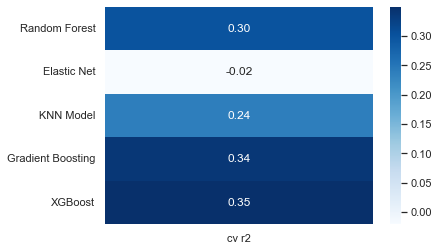

In [42]:
#sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(resultats_final[['cv r2']], annot=True, fmt=".2f", cmap="Blues")

<AxesSubplot:>

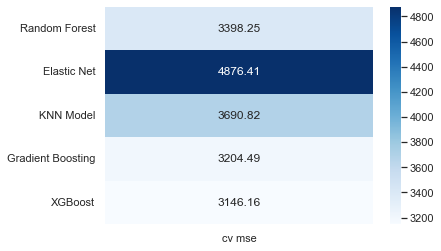

In [43]:
sns.heatmap(resultats_final[[ 'cv mse']], annot=True, fmt=".2f", cmap="Blues")

<AxesSubplot:>

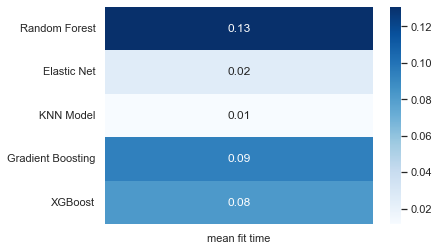

In [44]:
sns.heatmap(resultats_final[['mean fit time']], annot=True, fmt=".2f", cmap="Blues")

### Modèle sans EnergyStar

In [45]:
import numpy as np
import scipy as sp
import xgboost
import shap
import sklearn
from sklearn.model_selection import train_test_split

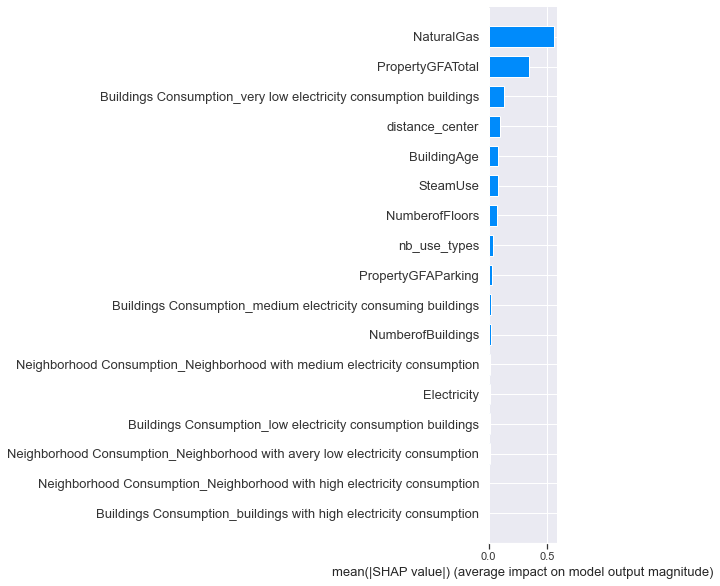

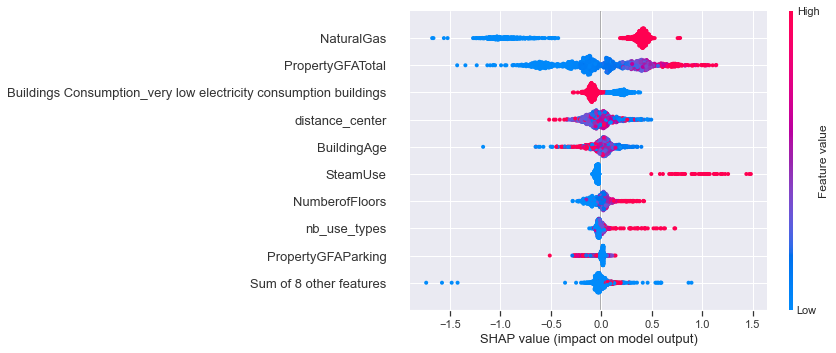

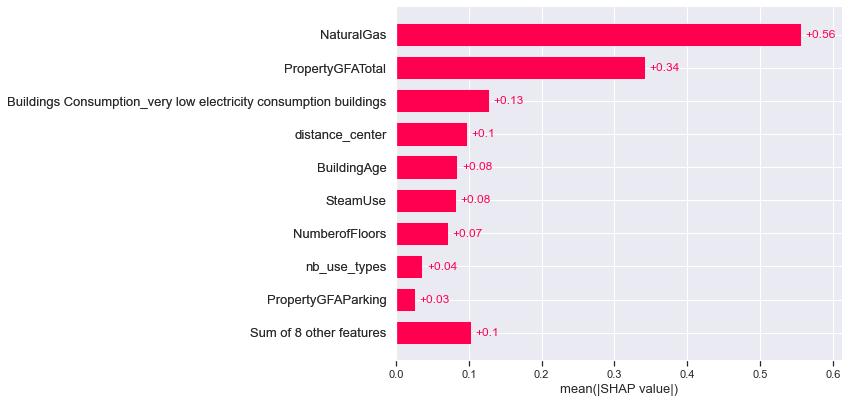

In [48]:
# Define the transformers
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

#colonne a transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Calibrage
preprocessor.fit(X_train)

#Transformation
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# Extraction des noms de variables
num_feature_names = preprocessor.transformers_[0][2]
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = num_feature_names + list(cat_feature_names)

# Calcul des valeurs SHAP pour chaque feature
explainer = shap.Explainer(grb_model[1]['transformer'].regressor_) #XGS
shap_values = explainer(X_train_transformed)

# Création d'un summary plot
shap.summary_plot(shap_values, X_train_transformed, plot_type="bar",feature_names=feature_names)

shap_values.feature_names = feature_names

shap.plots.beeswarm(shap_values)

# Création d'un bar plot
shap.plots.bar(shap_values)

In [49]:
import numpy as np
import scipy as sp
import xgboost
import shap
import sklearn
from sklearn.model_selection import train_test_split

### Meilleur Model avec ENERGYSTARScore

In [53]:
data_pipeline.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'distance_center', 'nb_use_types',
       'Electricity', 'SteamUse', 'NaturalGas', 'Buildings Consumption',
       'Neighborhood Consumption'],
      dtype='object')

In [54]:
#data = pd.read_csv('data.csv')
X = data_pipeline.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
y = data_pipeline['TotalGHGEmissions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the numeric features and categorical features
numeric_features = ['NumberofBuildings','NumberofFloors', 'PropertyGFAParking', 'PropertyGFATotal', 'BuildingAge',
                    'distance_center', 'nb_use_types', 'Electricity', 'SteamUse','NaturalGas', 'ENERGYSTARScore']
categorical_features = ['Buildings Consumption', 'Neighborhood Consumption']

In [55]:
def regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid):

    # Define the transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    # Combine the transformers into a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define the pipeline steps
    steps = [
        ('preprocessor', preprocessor),
        ('transformer', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1))
    ]
    # Create the pipeline
    pipeline = Pipeline(steps)

    # Define hyperparameters to tune
    param_grid = param_grid

    # Define the list of scoring functions
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }

    # Create the grid search object
    grid_search_ = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='mse')

    # Fit the pipeline to the training data
    grid_search_.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search_.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate mean squared error and R-squared
    mse_ = mean_squared_error(y_test, y_pred)
    r2_ = r2_score(y_test, y_pred)
    
    best_params=grid_search_.best_params_
    data_cv_results = pd.DataFrame(grid_search_.cv_results_)
    cv_r2 = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_r2"].values[0]
    cv_mse = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_mse"].values[0]*-1
    cv_meanfittime = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_fit_time"].values[0]
    
    # Print the results
    print('test mse:', mse_)
    print('test r2:', r2_)
    print('cv mse:', cv_mse)
    print('cv r2:', cv_r2)
    
    return best_params, best_model, [cv_r2, cv_mse, cv_meanfittime, mse_, r2_]

In [56]:
regressor = GradientBoostingRegressor()

# Define hyperparameters to tune
param_grid_grb = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__learning_rate': [0.1, 0.01, 0.001],
    'transformer__regressor__max_depth': [3, 4, 5],
    'transformer__regressor__min_samples_split': [2, 5, 10],
    'transformer__regressor__min_samples_leaf': [1, 2, 4],
    'transformer__regressor__max_features': ['sqrt', 'log2']
}

grb_model_2 = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_grb)

test mse: 3130.5912631922956
test r2: 0.3066655999813074
cv mse: 3052.1945828634302
cv r2: 0.36803072334557035


In [57]:
list_model = ['Gradient Boosting']
list_labels = ['cv r2','cv mse', 'mean fit time', 'test mse','test r2']
list_metrics = [grb_model[2]]

resultats_final = pd.DataFrame(list_metrics, index=list_model, columns=list_labels)

In [58]:
resultats_final

,cv r2,cv mse,mean fit time,test mse,test r2
Gradient Boosting,0.338195,3204.490775,0.094115,3391.411286,0.248902


<AxesSubplot:>

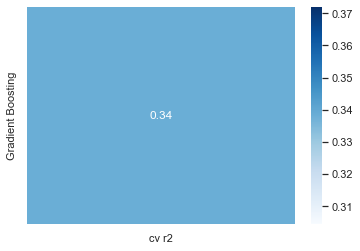

In [59]:
#sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(resultats_final[['cv r2']], annot=True, fmt=".2f", cmap="Blues")

<AxesSubplot:>

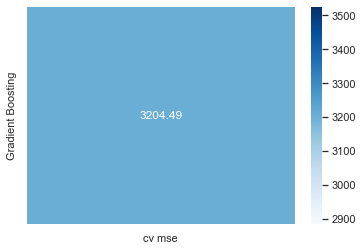

In [60]:
sns.heatmap(resultats_final[[ 'cv mse']], annot=True, fmt=".2f", cmap="Blues")

<AxesSubplot:>

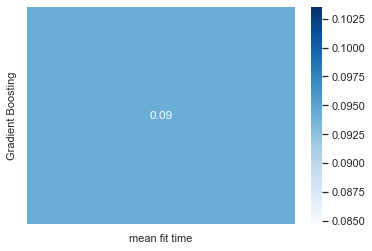

In [61]:
sns.heatmap(resultats_final[['mean fit time']], annot=True, fmt=".2f", cmap="Blues")

### Fitting a Linear Simulation with Gradient Boosting

In [62]:
import numpy as np
import scipy as sp
import xgboost
import shap
import sklearn
from sklearn.model_selection import train_test_split

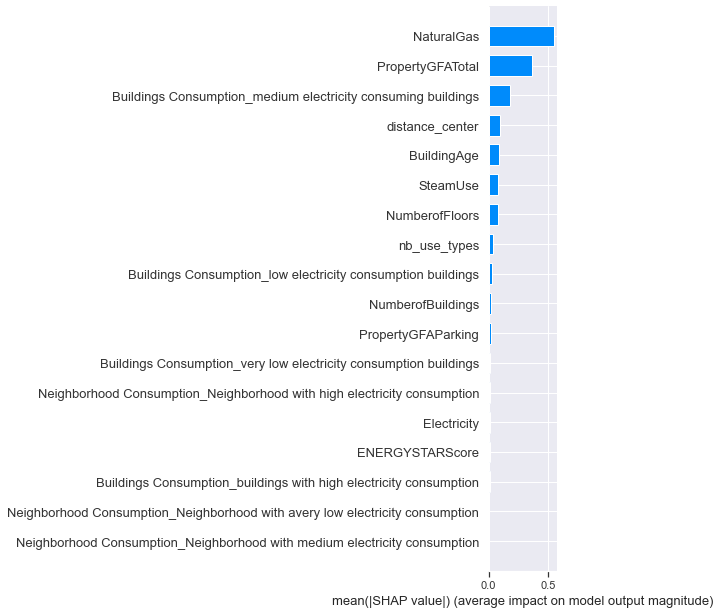

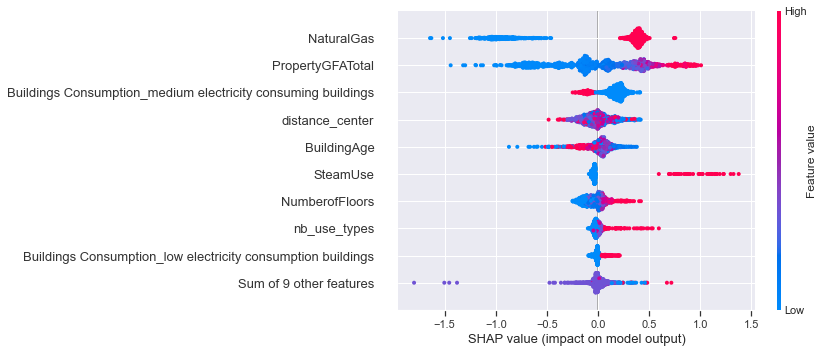

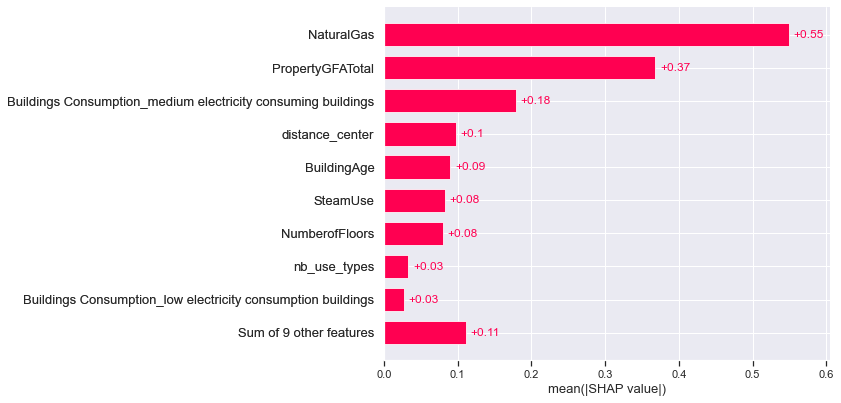

In [63]:
#colonne a transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Calibrage
preprocessor.fit(X_train)

#Transformation
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# Extraction des noms de variables
num_feature_names = preprocessor.transformers_[0][2]
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = num_feature_names + list(cat_feature_names)

# Calcul des valeurs SHAP pour chaque feature
explainer = shap.Explainer(grb_model[1]['transformer'].regressor_) #XGS
shap_values = explainer(X_train_transformed)

# Création d'un summary plot
shap.summary_plot(shap_values, X_train_transformed, plot_type="bar",feature_names=feature_names)

shap_values.feature_names = feature_names

shap.plots.beeswarm(shap_values)

# Création d'un bar plot
shap.plots.bar(shap_values)